In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


Some libraries and reading files

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

path = '/kaggle/input/competitive-data-science-predict-future-sales/'
items = pd.read_csv(path+'items.csv')
sales_train = pd.read_csv(path+'sales_train.csv')
item_categories = pd.read_csv(path+'item_categories.csv')
test = pd.read_csv(path+'test.csv')
shops = pd.read_csv(path+'shops.csv')


In [3]:
items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [4]:
sales_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [5]:
item_categories.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [6]:
test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [7]:
shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [8]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [9]:
sales_train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0


In [10]:
sales_train.date = pd.to_datetime(sales_train.date, format="%d.%m.%Y")


In [11]:
print("---------------------TRAIN-INFO----------------------")
print(sales_train.head())
print(sales_train.dtypes)
print(sales_train.info())
print(sales_train.shape)

---------------------TRAIN-INFO----------------------
        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0
date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3  

In [12]:
print("---------------------TEST-INFO----------------------")
print(test.head())
print(test.dtypes)
print(test.info())
print(test.shape)

---------------------TEST-INFO----------------------
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
ID         int64
shop_id    int64
item_id    int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None
(214200, 3)


Memory consumption reduction

In [13]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

sales_train = downcast_dtypes(sales_train)
print(sales_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int16         
 2   shop_id         int16         
 3   item_id         int16         
 4   item_price      float32       
 5   item_cnt_day    float32       
dtypes: datetime64[ns](1), float32(2), int16(3)
memory usage: 61.6 MB
None


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9277b64b50>,
      dtype=object)

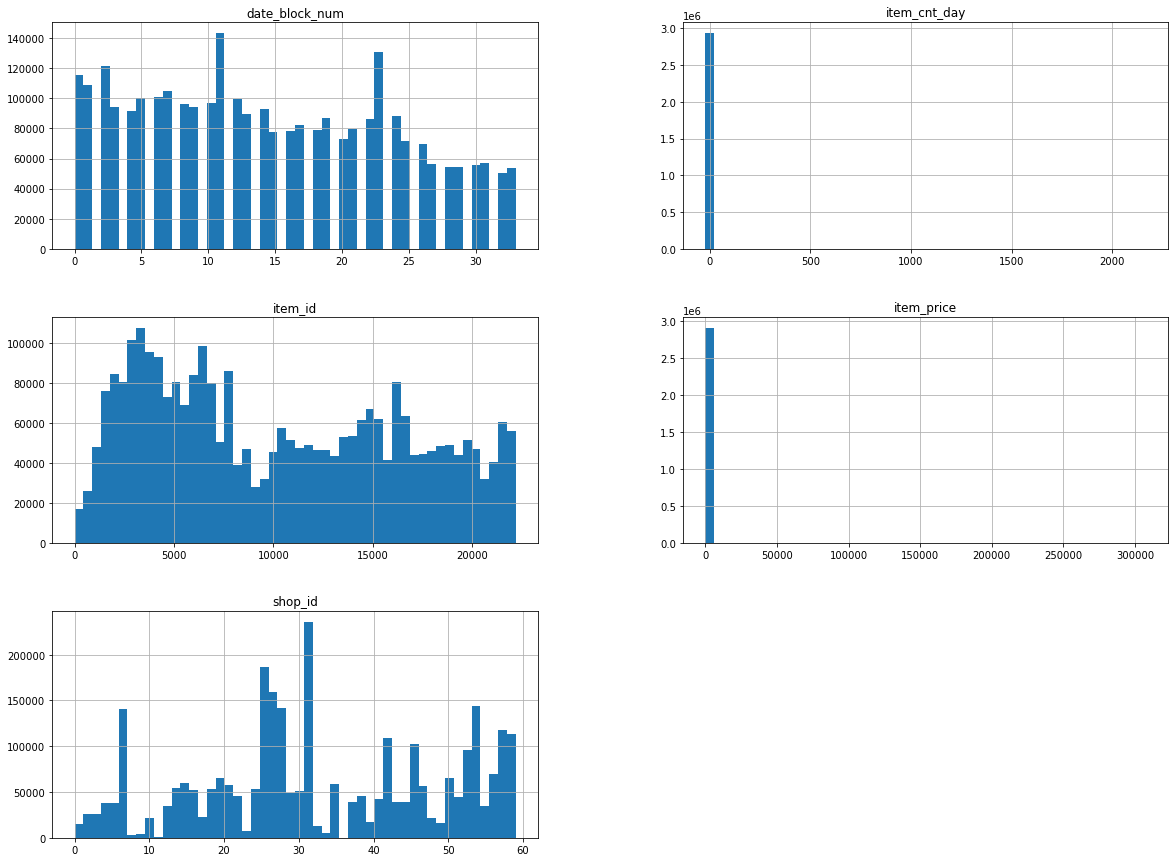

In [14]:
sales_train.hist(figsize=(20,15), bins=50)

Definition of target range. Second advice course

In [15]:
target_range = [0 ,20]

In [16]:
sales = pd.merge(sales_train, items, on='item_id', how='left')
sales = sales.drop('item_name', axis=1)
sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.000000,1.0,37
1,2013-01-03,0,25,2552,899.000000,1.0,58
2,2013-01-05,0,25,2552,899.000000,-1.0,58
3,2013-01-06,0,25,2554,1709.050049,1.0,58
4,2013-01-15,0,25,2555,1099.000000,1.0,56
5,2013-01-10,0,25,2564,349.000000,1.0,59
6,2013-01-02,0,25,2565,549.000000,1.0,56
7,2013-01-04,0,25,2572,239.000000,1.0,55
8,2013-01-11,0,25,2572,299.000000,1.0,55
9,2013-01-03,0,25,2573,299.000000,3.0,55


In [17]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
from itertools import product

In [18]:
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

In [19]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


Mean encodings

In [20]:
mean_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum', 'item_price': np.mean}).reset_index()

In [21]:
mean_sales = pd.merge(grid, mean_sales, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
mean_sales = pd.merge(mean_sales, items, on='item_id', how='left')

Additional part Mean encoding

In [22]:
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        
        mean_df = sales.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        mean_sales = pd.merge(mean_sales, mean_df, on=['date_block_num',type_id], how='left')

In [23]:
mean_sales.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,18.0,1.0,820.174561,2017.0,1.092041,465.036011,6094.0,1.053414
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.0,0.0,820.174561,2017.0,1.092041,1401.858154,287.0,0.969595
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050049,1.0,1.0,820.174561,2017.0,1.092041,1401.858154,287.0,0.969595
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.849976,2.0,1.0,820.174561,2017.0,1.092041,867.447021,268.0,1.007519
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600006,5.0,1.0,820.174561,2017.0,1.092041,443.330017,701.0,0.990113


Lag variables

In [24]:
lag_variables = list(mean_sales.columns[7:])+['item_cnt_day']
lags = [1, 2, 3, 6]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_sales.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num', 'shop_id', 'item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num', 'shop_id', 'item_id'] + [lag_feat+ '_lag_'+str(lag) for lag_feat in lag_variables]
    mean_sales = pd.merge(mean_sales, sales_new_df, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    

In [25]:
mean_sales.head(10)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,...,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,18.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050049,1.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.849976,2.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600006,5.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,2.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333344,12.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,16.0,1.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986542,119.0,1.144231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.199997,5.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Fill NA with zeros

In [26]:
mean_sales = mean_sales[mean_sales['date_block_num']>12]

In [27]:
for feat in mean_sales.columns:
    if 'item_cnt' in feat:
        mean_sales[feat] = mean_sales[feat].fillna(0)
    elif 'item_price' in feat:
        mean_sales[feat] = mean_sales[feat].fillna(mean_sales[feat].median())


In [28]:
cols_to_drop = lag_variables[:-1] + ['item_price', 'item_name']

In [29]:
training = mean_sales.drop(cols_to_drop, axis=1)

Train XGBoost model

In [30]:
xgbtrain = xgb.DMatrix(training.iloc[:, training.columns != 'item_cnt_day'].values, training.iloc[:, training.columns == 'item_cnt_day'].values)

In [31]:
params = {
    'max_depth': 10,
    'subsample': 1,
    'min_child_weight': 0.5,
    'eta': 0.3,
    'num_round': 1000,
    'seed': 1,
    'silent': 0,
    'eval_metric': 'rmse'
}
boost = xgb.train(params, xgbtrain)

[20:06:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:06:05] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


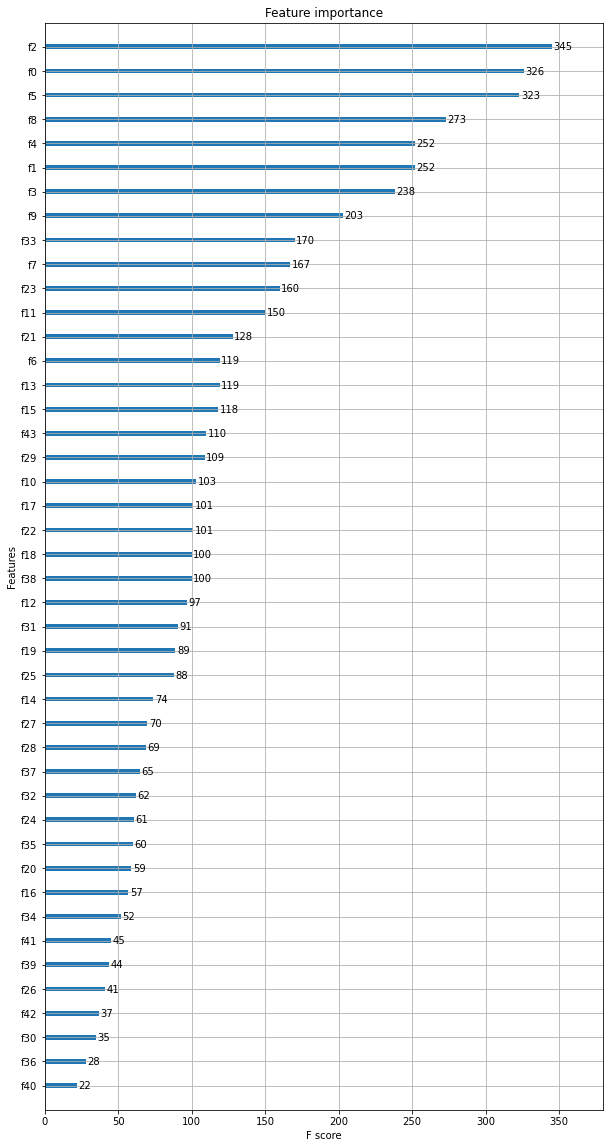

In [32]:
x = xgb.plot_importance(boost)
x.figure.set_size_inches(10,20)

In [33]:
cols = list(training.columns)
del cols[cols.index('item_cnt_day')]

In [34]:
[cols[x] for x in [2, 0, 1, 3, 5]]

['date_block_num',
 'shop_id',
 'item_id',
 'item_category_id',
 'item_id_sum_item_cnt_day_lag_1']

In [35]:
training.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_day',
       'item_category_id', 'item_id_avg_item_price_lag_1',
       'item_id_sum_item_cnt_day_lag_1', 'item_id_avg_item_cnt_day_lag_1',
       'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_day_lag_1',
       'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_day_lag_2', 'shop_id_avg_item_cnt_day_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_day_lag_2',
       'item_category_id_avg_item_cnt_day_lag_2', 'item_cnt_day_lag_2',
       'item_id_avg_item_price_lag_3', 'item_id_sum_item_cnt_day_lag_3',
       'item_id_avg_item_cnt_day_lag_3', 'shop_id_avg_i

In [36]:
test = pd.read_csv(path+'test.csv')

In [37]:
print("--------------------Test-Info------------------")
print(test.head())
print(test.info())
print(test.columns)

--------------------Test-Info------------------
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None
Index(['ID', 'shop_id', 'item_id'], dtype='object')


In [38]:
test['date_block_num'] = 34
test = pd.merge(test, items, on='item_id', how='left')

In [39]:
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_sales.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num', 'shop_id', 'item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num', 'shop_id', 'item_id'] + [lag_feat+ '_lag_'+str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    

In [40]:
df_test = set(test.drop(['ID', 'item_name'], axis=1).columns)
df_training = set(training.drop('item_cnt_day', axis=1).columns)
for i in df_test:
    assert i in df_training
for j in df_training:
    assert j in df_test

In [41]:
assert df_training == df_test

In [42]:
test = test.drop(['ID', 'item_name'], axis=1)
for feat in test.columns:
    if 'item_cnt' in feat:
        test[feat]=test[feat].fillna(0)
    elif 'item_price' in feat:
        test[feat] = test[feat].fillna(test[feat].median())

In [43]:
test[['shop_id', 'item_id']+['item_cnt_day_lag_'+str(x) for x in[1,2,3]]].head()

,shop_id,item_id,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3
0,5,5037,0.0,1.0,3.0
1,5,5320,0.0,0.0,0.0
2,5,5233,1.0,3.0,1.0
3,5,5232,0.0,0.0,1.0
4,5,5268,0.0,0.0,0.0


Forecasting monthly sales

In [44]:
xgbpredict = xgb.DMatrix(test.values)
pred = boost.predict(xgbpredict)
pd.Series(pred).describe()

count    214200.000000
mean          0.323648
std           2.885349
min          -1.375026
25%           0.053303
50%           0.126877
75%           0.269293
max         693.166992
dtype: float64

In [45]:
pred = pred.clip(0, 20)
pd.Series(pred).describe()

count    214200.000000
mean          0.300098
std           0.795493
min           0.000000
25%           0.053303
50%           0.126877
75%           0.269293
max          20.000000
dtype: float64

In [46]:
submission_df = pd.DataFrame({'ID': test.index, 'item_cnt_month': pred})
submission_df.head(10)

,ID,item_cnt_month
0,0,0.777840
1,1,0.252477
2,2,1.046677
3,3,0.374081
4,4,4.181317
5,5,0.578045
6,6,1.086632
7,7,0.099693
8,8,0.669394
9,9,0.427087


In [47]:
submission_df.to_csv('submission_xgboost.csv', index=False)